In [151]:
import copy
import sys
import os

from isca_tools.utils.numerical import polyfit_phase

# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat, get_density, virtual_temp, saturation_vapor_pressure
from isca_tools.utils.constants import kappa, L_v, c_p, c_p_water, rho_water, Stefan_Boltzmann, R, R_v
from isca_tools.utils import area_weighting, annual_mean, annual_time_slice, anom_from_annual_mean, print_ds_var_list, numerical
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import get_temp_adiabat, get_temp_adiabat_surf
from isca_tools.convection.simple_betts_miller import lcl_temp, ref_temp_above_lcl, get_temp_ref
from isca_tools.convection import dry_profile_pressure, moist_profile, potential_temp
import isca_tools.utils.fourier as fourier
from isca_tools.utils.radiation import get_heat_capacity
from isca_tools.plot import colored_line, fig_resize, update_fontsize, update_linewidth, savefig
from isca_tools.thesis.surface_energy_budget import get_temp_fourier_analytic, get_temp_fourier_numerical, get_temp_extrema_analytic,\
    get_temp_extrema_numerical
from isca_tools.plot import label_subplots
from isca_tools.utils.calculus import grad_y
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm.notebook import tqdm
import pandas as pd
from scipy import optimize, ndimage
import warnings
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
plt.rcParams['lines.linewidth'] = 0.8

In [175]:
exp_dir = 'aquaplanet/latent_heat_temp_only/'
exp_name = ['evap=0_1', 'depth=20/base']

var_keep = ['temp', 'sphum', 'height', 't_surf', 'swdn_sfc', 'lwup_sfc', 'lwdn_sfc',
            'flux_lhe', 'flux_t']
# get_heat_capacity(c_p_water)

# Get low level sigma level
namelist = isca_tools.load_namelist(exp_dir+exp_name[0])
p_surface_approx = namelist['spectral_dynamics_nml']['reference_sea_level_press']/100
sigma_levels_half = np.asarray(namelist['vert_coordinate_nml']['bk'])
sigma_levels_full = np.convolve(sigma_levels_half, np.ones(2)/2, 'valid')
sigma_near_surf = sigma_levels_full[-1]

n_exp = len(exp_name)
lat_range = slice(30, 90)               # only consider NH and outside deep tropics, and ignore high latitudes as need 2nd harmonic there
use_time_start = 2          # all after 2 years
ds_base = []
for i in tqdm(range(n_exp)):
    ds_use = isca_tools.load_dataset(exp_dir + exp_name[i], decode_times=True)
    try:
        ds_use = ds_use[var_keep]
    except KeyError:
        remove_keys = []
        for key in var_keep:
            if key not in ds_use:
                print(f'Removing {key} from var_keep')
                remove_keys += [key]
        for key in remove_keys:
            var_keep.remove(key)
        ds_use = ds_use[var_keep]
    ds_use = ds_use.sel(time=ds_use.time.dt.year>use_time_start, lat=lat_range)
    ds_use = ds_use.sel(pfull=np.inf, method='nearest')      # only keep lowest level
    # Compute variables required for flux breakdown
    ds_use['net_fluxup_sfc'] = ds_use.lwup_sfc - ds_use.lwdn_sfc + ds_use.flux_lhe + ds_use.flux_t
    ds_base += [ds_use.load()]      # only keep after spin up
mixed_layer_depth = [isca_tools.load_namelist(exp_dir+exp_name[i])['mixed_layer_nml']['depth'] for i in range(n_exp)]
heat_capacity = [get_heat_capacity(c_p_water, mixed_layer_depth[i], rho_water) for i in range(n_exp)]

  0%|          | 0/2 [00:00<?, ?it/s]

Removing height from var_keep


/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:57: UserWarning: First month saved is 121 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')


In [176]:
def get_annual_zonal_mean(ds):
    ds = ds.groupby("time.dayofyear").mean(dim="time").mean(dim='lon')
    ds['dayofyear'] = ds['dayofyear'] - 1           # for fourier stuff, expect first time index to be 0
    return ds

smooth_sz = 20   # smooth over 20 days
def get_smooth(ds, window=smooth_sz, dim='dayofyear'):
    if dim not in ds.dims:
        raise ValueError(f"Dimension '{dim}' not found in dataset.")
    ds_use = ds.pad({dim: window // 2}, mode="wrap")
    # Apply rolling mean
    ds_use = ds_use.rolling({dim: window}, center=True).mean()
    # Remove padding to keep the original time length
    ds_use = ds_use.isel({dim: slice(window // 2, -window // 2)})
    return ds_use

def get_anom(var, dim='dayofyear'):
    return var - var.mean(dim=dim)

In [177]:
# Get smoothed annual zonal mean arrays
ds = [get_smooth(get_annual_zonal_mean(ds_base[i])) for i in range(n_exp)]
n_lat = ds[0].lat.size
n_time = ds[0].dayofyear.size

In [178]:
sw_amp_coefs = {key: np.zeros((n_exp, n_lat, 1+int(key.replace('_harmonic', '')))) for key in ['1_harmonic', '2_harmonic']}
sw_fourier_fit = {key: np.zeros((n_exp, n_lat, n_time)) for key in ['1_harmonic', '2_harmonic']}
# temp_anom_fourier_fit = {key: np.zeros((n_lat, n_time)) for key in ['1_harmonic', '2_harmonic']}
for key in sw_amp_coefs:
    for j in range(n_exp):
        for i in range(n_lat):
            sw_amp_coefs[key][j, i] = fourier.get_fourier_fit(ds[j].dayofyear, ds[j].swdn_sfc[:, i], int(key.replace('_harmonic', '')))[1]
            # Fit SW fourier with no phase
            sw_fourier_fit[key][j, i] = fourier.fourier_series(ds[j].dayofyear, sw_amp_coefs[key][j, i], np.zeros(int(key.replace('_harmonic', ''))))
# Record phase of maxima / minima relative to extrema times of 1st harmonic of SW radiation
time_extrema_sw = {'min': int(ds[0].dayofyear[0]), 'max': int(ds[0].dayofyear[int(n_time/2)])}
time_extrema_temp = {key: {key2: np.zeros((n_exp, n_lat)) for key2 in ['simulated', '1_harmonic', '2_harmonic']} for key in ['min', 'max']}
amp_extrema_temp = {key: {key2: np.zeros((n_exp, n_lat)) for key2 in ['simulated', '1_harmonic', '2_harmonic']} for key in ['min', 'max']}

smooth_ndays_temp_extrema = 1            # already smoothed so no smoothing for finding extrema
for j in range(n_exp):
    for i in range(n_lat):
        # No smoothing for '1_harmonic' as already fit smooth fourier solution
        time_extrema_temp['min']['simulated'][j, i], time_extrema_temp['max']['simulated'][j, i], \
            amp_extrema_temp['min']['simulated'][j, i], amp_extrema_temp['max']['simulated'][j, i] = \
            get_temp_extrema_numerical(ds[j].dayofyear, get_anom(ds[j].t_surf.isel(lat=i)), smooth_ndays_temp_extrema)

In [179]:
gamma_params = np.zeros((n_exp, n_lat, 2))
for i in range(n_exp):
    for j in range(n_lat):
        # Compute gamma from the smoothed arrays
        gamma_params[i, j] = np.polyfit(get_anom(ds[i].t_surf.isel(lat=j)),
                                        ds[i].net_fluxup_sfc.isel(lat=j), 1)

In [180]:
swdn_sfc_eff = np.zeros((n_exp, n_lat, n_time))
sw_eff_amp_coefs = {key: np.zeros((n_exp, n_lat, 1+int(key.replace('_harmonic', '')))) for key in ['1_harmonic', '2_harmonic']}
temp_anom_approx = {key: np.zeros((n_exp, n_lat, n_time)) for key in sw_eff_amp_coefs}
for key in sw_eff_amp_coefs:
    for i in range(n_exp):
        for j in range(n_lat):
            ds_use = ds[i].isel(lat=j)
            gamma_resid = ds_use.net_fluxup_sfc - np.polyval(gamma_params[i, j], get_anom(ds_use.t_surf))
            # Effective shortwave radiation is shortwave minus all of gamma that cannot be explained through a linear fit
            swdn_sfc_eff[i, j] = ds_use.swdn_sfc - gamma_resid
            temp_anom_approx[key][i, j], _, _, sw_eff_amp_coefs[key][i, j], _ = \
                get_temp_fourier_analytic(ds_use.dayofyear, swdn_sfc_eff[i, j], heat_capacity[i],
                                          gamma_params[i, j, 0], n_harmonics_sw=int(key[0]))
            if '1' in key:
                time_extrema_temp['min'][key][i, j], time_extrema_temp['max'][key][i, j], \
                    amp_extrema_temp['min'][key][i, j], amp_extrema_temp['max'][key][i, j] = \
                    get_temp_extrema_analytic(sw_eff_amp_coefs[key][i, j, 1], heat_capacity[i], gamma_params[i, j, 0])
            else:
                time_extrema_temp['min'][key][i, j], time_extrema_temp['max'][key][i, j], \
                    amp_extrema_temp['min'][key][i, j], amp_extrema_temp['max'][key][i, j] = \
                    get_temp_extrema_numerical(ds_use.dayofyear, temp_anom_approx[key][i, j], smooth_window=1)

### Schematic of seasonal cycle

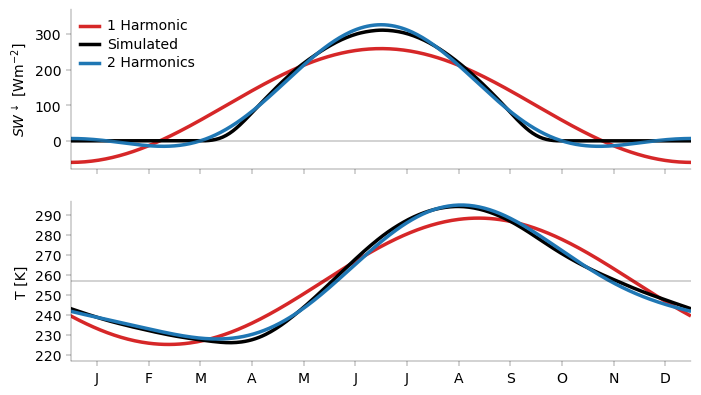

In [568]:
i = 0
lat_plot_ind = -1
t_plot_mean = float(ds[i].t_surf.isel(lat=lat_plot_ind).mean())
fig, ax = plt.subplots(2,1, sharex=True)
fig_resize(fig, 8, ar=3.5)
ax[0].plot(ds[0].dayofyear, fourier.fourier_series(ds[0].dayofyear, sw_eff_amp_coefs['1_harmonic'][i, lat_plot_ind], [0, 0]),
           color='C3', label='1 Harmonic')
ax[1].plot(ds[0].dayofyear, temp_anom_approx['1_harmonic'][i, lat_plot_ind]+t_plot_mean, color='C3')

ax[0].plot(ds[0].dayofyear, ds[i].swdn_sfc.isel(lat=lat_plot_ind), color='k', label='Simulated')
ax[1].plot(ds[0].dayofyear, ds[i].t_surf.isel(lat=lat_plot_ind), color='k')
#
ax[0].plot(ds[0].dayofyear, fourier.fourier_series(ds[0].dayofyear, sw_eff_amp_coefs['2_harmonic'][i, lat_plot_ind], [0, 0, 0]),
           color='C0', label='2 Harmonics')
ax[1].plot(ds[0].dayofyear, temp_anom_approx['2_harmonic'][i, lat_plot_ind]+t_plot_mean, color='C0')

update_linewidth(fig)
ax[0].legend(loc='upper left')
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[1].axhline(t_plot_mean, color='k', lw=ax_linewidth)

ax[0].set_xlim(0, 360)
ax[0].set_ylim(-80, 370)
ax[1].set_ylim(-40+t_plot_mean, 40+t_plot_mean)
ax[0].set_ylabel('$SW^{\downarrow}$ [Wm$^{-2}$]')
ax[1].set_ylabel('T [K]')

month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])
ax[0].set_xticks(*month_ticks)
update_fontsize(fig, base_fontsize=4)
# savefig(fig)

In [181]:
const_lat_ind = 0
const_params = {'sw1': sw_eff_amp_coefs['1_harmonic'][:, const_lat_ind, 1], 'sw2':[1e-10, 1e-10],
                'gamma_param': gamma_params[:, const_lat_ind, 0]}

In [182]:
const_params

{'sw1': array([-80.50364459, -93.38984008]),
 'sw2': [1e-10, 1e-10],
 'gamma_param': array([3.49095098, 4.10767242])}

In [183]:
time_extrema_temp_cont = {key: {key2: np.zeros((n_exp, n_lat)) for key2 in ['min', 'max']} for key in
                          ['sw1', 'sw2', 'gamma_param']}
amp_extrema_temp_cont = {key: {key2: np.zeros((n_exp, n_lat)) for key2 in ['min', 'max']} for key in
                          ['sw1', 'sw2', 'gamma_param']}
# sw1
for i in range(n_exp):
    for j in range(n_lat):
        ds_use = ds[i].isel(lat=j)
        time_min_use, time_max_use, amp_min_use, amp_max_use = \
            get_temp_extrema_analytic(sw_eff_amp_coefs['1_harmonic'][i, j, 1], heat_capacity[i], const_params['gamma_param'][i])
        time_extrema_temp_cont['sw1']['min'][i, j] = time_min_use - time_extrema_temp['min']['1_harmonic'][i, const_lat_ind]
        time_extrema_temp_cont['sw1']['max'][i, j] = time_max_use - time_extrema_temp['max']['1_harmonic'][i, const_lat_ind]
        amp_extrema_temp_cont['sw1']['min'][i, j] = amp_min_use - amp_extrema_temp['min']['1_harmonic'][i, const_lat_ind]
        amp_extrema_temp_cont['sw1']['max'][i, j] = amp_max_use - amp_extrema_temp['max']['1_harmonic'][i, const_lat_ind]


# gamma_param
for i in range(n_exp):
    for j in range(n_lat):
        ds_use = ds[i].isel(lat=j)
        time_min_use, time_max_use, amp_min_use, amp_max_use = \
            get_temp_extrema_analytic(const_params['sw1'][i], heat_capacity[i], gamma_params[i, j, 0])
        time_extrema_temp_cont['gamma_param']['min'][i, j] = time_min_use - time_extrema_temp['min']['1_harmonic'][i, const_lat_ind]
        time_extrema_temp_cont['gamma_param']['max'][i, j] = time_max_use - time_extrema_temp['max']['1_harmonic'][i, const_lat_ind]
        amp_extrema_temp_cont['gamma_param']['min'][i, j] = amp_min_use - amp_extrema_temp['min']['1_harmonic'][i, const_lat_ind]
        amp_extrema_temp_cont['gamma_param']['max'][i, j] = amp_max_use - amp_extrema_temp['max']['1_harmonic'][i, const_lat_ind]

# sw2/sw1
for i in range(n_exp):
    for j in range(n_lat):
        ds_use = ds[i].isel(lat=j)
        coef_use = [sw_eff_amp_coefs['1_harmonic'][i, j, 0], const_params['sw1'][i],
                    const_params['sw1'][i] * sw_eff_amp_coefs['2_harmonic'][i, j, 2]/sw_eff_amp_coefs['2_harmonic'][i, j, 1]]
        sw_use = fourier.fourier_series(ds[0].dayofyear, coef_use, [0, 0])
        temp_anom_use = \
            get_temp_fourier_analytic(ds_use.dayofyear, sw_use, heat_capacity[i],
                                      const_params['gamma_param'][i], n_harmonics_sw=int(key[0]))[0]
        time_min_use, time_max_use, amp_min_use, amp_max_use = \
            get_temp_extrema_numerical(ds_use.dayofyear, temp_anom_use, smooth_window=1)
        time_extrema_temp_cont['sw2']['min'][i, j] = time_min_use - time_extrema_temp['min']['1_harmonic'][i, const_lat_ind]
        time_extrema_temp_cont['sw2']['max'][i, j] = time_max_use - time_extrema_temp['max']['1_harmonic'][i, const_lat_ind]
        amp_extrema_temp_cont['sw2']['min'][i, j] = amp_min_use - amp_extrema_temp['min']['1_harmonic'][i, const_lat_ind]
        amp_extrema_temp_cont['sw2']['max'][i, j] = amp_max_use - amp_extrema_temp['max']['1_harmonic'][i, const_lat_ind]

In [328]:
linestyle = {'max': None, 'min': ':', 0: None, 1: '--'}
ax_linewidth = plt.rcParams['axes.linewidth']
lat_ax_lims = [30, 90]
amp_ax_lims = [5, 40]

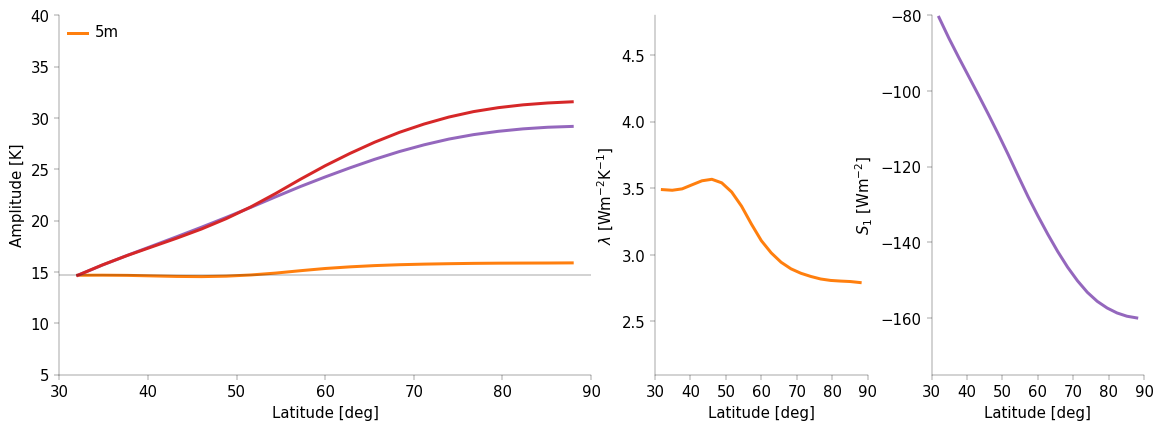

In [528]:
i = 1
fig, ax = plt.subplots(1,3, sharex=True, gridspec_kw={'width_ratios': [5, 2, 2]})
fig_resize(fig, 14, ar=1)

key = 'max'
for i in range(n_exp-1):
    ax[0].plot(ds[0].lat, amp_extrema_temp_cont['gamma_param'][key][i]+amp_extrema_temp[key]['1_harmonic'][i, 0],
           color='C1', linestyle=linestyle[i], label=f"{mixed_layer_depth[i]:.0f}m")
    ax[1].plot(ds[0].lat, gamma_params[i, :, 0], color='C1', linestyle=linestyle[i])
    ax[0].plot(ds[0].lat, amp_extrema_temp_cont['sw1'][key][i]+amp_extrema_temp[key]['1_harmonic'][i, 0],
       color='C4', linestyle=linestyle[i])
    ax[0].plot(ds[0].lat, amp_extrema_temp[key]['1_harmonic'][i], color='C3', linestyle=linestyle[i])
    ax[2].plot(ds[0].lat, sw_eff_amp_coefs['2_harmonic'][i, :, 1], color='C4', linestyle=linestyle[i])
update_linewidth(fig)
for i in range(n_exp-1):
    ax[0].axhline(amp_extrema_temp[key]['1_harmonic'][i, const_lat_ind], color='k', lw=ax_linewidth)
ax[0].set_ylabel('Amplitude [K]')
ax[1].set_ylabel('$\lambda$ [Wm$^{-2}$K$^{-1}$]')
ax[2].set_ylabel('$S_1$ [Wm$^{-2}$]')
for i in range(3):
    ax[i].set_xlabel('Latitude [deg]')
ax[0].legend(loc='upper left')
update_fontsize(fig, base_fontsize=5)
ax[1].set_ylim(2.1, 4.8)
ax[2].set_ylim(-175, -80)
ax[0].set_xlim(lat_ax_lims)
ax[0].set_ylim(amp_ax_lims)
# savefig(fig)
plt.show()

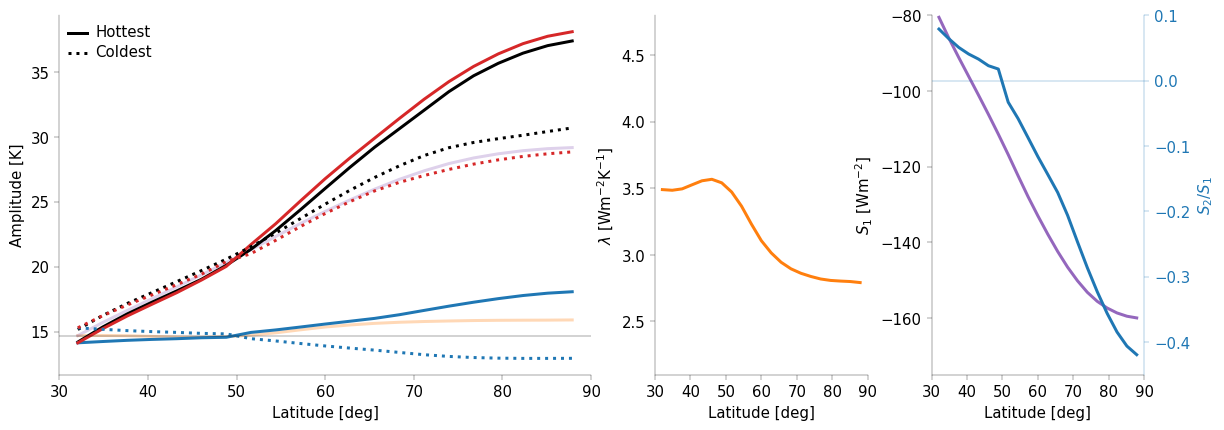

In [562]:
i=0
fig, ax = plt.subplots(1,3, sharex=True, gridspec_kw={'width_ratios': [5, 2, 2]})
fig_resize(fig, 14, ar=1)

ax[0].plot(ds[0].lat, amp_extrema_temp_cont['gamma_param'][key][i]+amp_extrema_temp[key]['1_harmonic'][i, 0],
       color='C1', alpha=0.3)
ax[0].plot(ds[0].lat, amp_extrema_temp_cont['sw1'][key][i]+amp_extrema_temp[key]['1_harmonic'][i, 0],
       color='C4', alpha=0.3)
# ax[0].plot(ds[0].lat, amp_extrema_temp[key]['1_harmonic'][i], color='C3', linestyle=linestyle[i])
for key in ['max', 'min']:
    ax[0].plot(ds[0].lat, amp_extrema_temp[key]['simulated'][i], color='k', linestyle=linestyle[key], label='Hottest' if key == 'max' else 'Coldest')
    ax[0].plot(ds[0].lat, amp_extrema_temp_cont['sw2'][key][i]+amp_extrema_temp[key]['1_harmonic'][i, 0],
       color='C0', linestyle=linestyle[key])
    ax[0].plot(ds[0].lat, amp_extrema_temp[key]['2_harmonic'][i], color='C3', linestyle=linestyle[key])

ax[1].plot(ds[0].lat, gamma_params[i, :, 0], color='C1')
ax[2].plot(ds[0].lat, sw_eff_amp_coefs['2_harmonic'][i, :, 1], color='C4')

ax2 = ax[2].twinx()
ax2.spines['right'].set_visible(True)
ax2.spines[['left', 'bottom']].set_visible(False)
ax2.plot(ds[0].lat, sw_eff_amp_coefs['2_harmonic'][i, :, 2]/sw_eff_amp_coefs['2_harmonic'][i, :, 1], color='C0')
ax2.set_ylabel('$S_2/S_1$', color='C0')
ax2.spines['right'].set_color('C0')
ax2.tick_params(axis='y', colors='C0')
ax2.set_ylim(-0.45, 0.1)

update_linewidth(fig)
ax2.axhline(0, color='C0', lw=ax_linewidth)
ax[0].axhline(amp_extrema_temp[key]['1_harmonic'][i, const_lat_ind], color='k', lw=ax_linewidth)

ax[0].set_ylabel('Amplitude [K]')
ax[1].set_ylabel('$\lambda$ [Wm$^{-2}$K$^{-1}$]')
ax[2].set_ylabel('$S_1$ [Wm$^{-2}$]')
for i in range(3):
    ax[i].set_xlabel('Latitude [deg]')
ax[0].legend(loc='upper left')
update_fontsize(fig, base_fontsize=5)
ax[1].set_ylim(2.1, 4.8)
ax[2].set_ylim(-175, -80)
ax[0].set_xlim(lat_ax_lims)
if i == 0:
    ax[0].set_ylim(amp_ax_lims)
# savefig(fig)
plt.show()

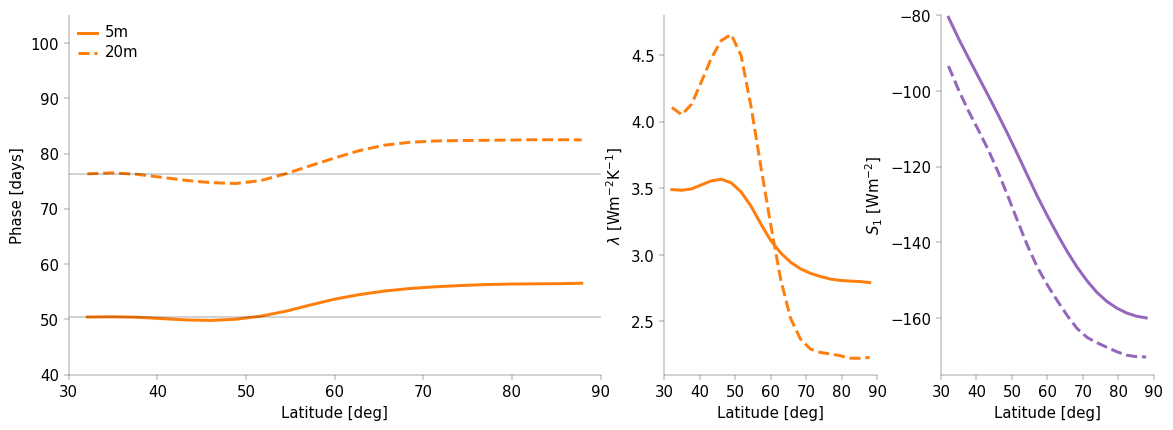

In [567]:
fig, ax = plt.subplots(1,3, sharex=True, gridspec_kw={'width_ratios': [5, 2, 2]})
fig_resize(fig, 14, ar=1)

key = 'max'
# ax[0].plot(ds[0].lat, amp_extrema_temp[key]['simulated'][i], color='k', linestyle=linestyle[key])
for i in range(n_exp):
    # ax[0].plot(ds[0].lat, time_extrema_temp[key]['1_harmonic'][i]-time_extrema_sw[key], color='C3',
    #            linestyle=linestyle[i], label=f"{mixed_layer_depth[i]:.0f}m")
    ax[0].plot(ds[0].lat, time_extrema_temp_cont['gamma_param'][key][i]+time_extrema_temp[key]['1_harmonic'][i, 0]-time_extrema_sw[key],
           color='C1', linestyle=linestyle[i], label=f"{mixed_layer_depth[i]:.0f}m")
    ax[1].plot(ds[0].lat, gamma_params[i, :, 0], color='C1', linestyle=linestyle[i])
    ax[2].plot(ds[0].lat, sw_eff_amp_coefs['2_harmonic'][i, :, 1], color='C4', linestyle=linestyle[i])
update_linewidth(fig)
for i in range(n_exp):
    ax[0].axhline(time_extrema_temp[key]['1_harmonic'][i, const_lat_ind]-time_extrema_sw[key], color='k', lw=ax_linewidth)
ax[0].set_ylabel('Phase [days]')
ax[1].set_ylabel('$\lambda$ [Wm$^{-2}$K$^{-1}$]')
ax[2].set_ylabel('$S_1$ [Wm$^{-2}$]')
ax[0].legend(loc='upper left')
for i in range(3):
    ax[i].set_xlabel('Latitude [deg]')
update_fontsize(fig, base_fontsize=5)
ax[0].set_ylim(40, 105)
ax[1].set_ylim(2.1, 4.8)
ax[2].set_ylim(-175, -80)
ax[0].set_xlim(lat_ax_lims)
# savefig(fig)
plt.show()

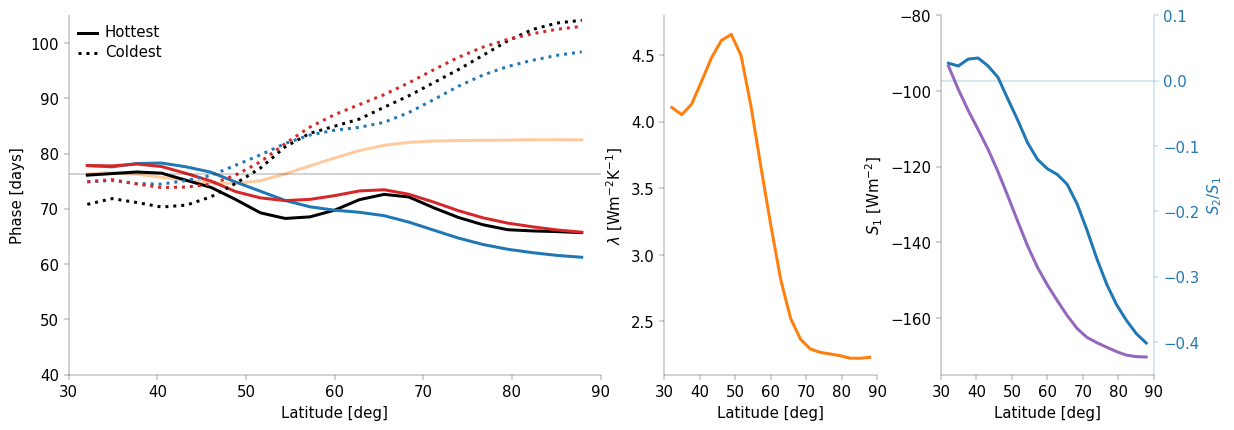

In [566]:
i=1
fig, ax = plt.subplots(1,3, sharex=True, gridspec_kw={'width_ratios': [5, 2, 2]})
fig_resize(fig, 14, ar=1)

key = 'max'
# ax[0].plot(ds[0].lat, amp_extrema_temp[key]['simulated'][i], color='k', linestyle=linestyle[key])
# ax[0].plot(ds[0].lat, time_extrema_temp[key]['1_harmonic'][i]-time_extrema_sw[key], color='C3',
#            linestyle=linestyle[i])
ax[0].plot(ds[0].lat, time_extrema_temp_cont['gamma_param'][key][i]+time_extrema_temp[key]['1_harmonic'][i, 0]-time_extrema_sw[key],
       color='C1', alpha=0.4)
ax[1].plot(ds[0].lat, gamma_params[i, :, 0], color='C1')
ax[2].plot(ds[0].lat, sw_eff_amp_coefs['2_harmonic'][i, :, 1], color='C4')

for key in ['max', 'min']:
    ax[0].plot(ds[0].lat, time_extrema_temp[key]['simulated'][i]-time_extrema_sw[key], color='k', linestyle=linestyle[key],
               label='Hottest' if key=='max' else 'Coldest')
    ax[0].plot(ds[0].lat, time_extrema_temp_cont['sw2'][key][i]+time_extrema_temp[key]['1_harmonic'][i, 0]-time_extrema_sw[key],
       color='C0', linestyle=linestyle[key])
    ax[0].plot(ds[0].lat, time_extrema_temp[key]['2_harmonic'][i]-time_extrema_sw[key], color='C3', linestyle=linestyle[key])

ax2 = ax[2].twinx()
ax2.spines['right'].set_visible(True)
ax2.spines[['left', 'bottom']].set_visible(False)
ax2.plot(ds[0].lat, sw_eff_amp_coefs['2_harmonic'][i, :, 2]/sw_eff_amp_coefs['2_harmonic'][i, :, 1], color='C0')
ax2.set_ylabel('$S_2/S_1$', color='C0')
ax2.spines['right'].set_color('C0')
ax2.tick_params(axis='y', colors='C0')
ax2.set_ylim(-0.45, 0.1)

update_linewidth(fig)
ax2.axhline(0, color='C0', lw=ax_linewidth)
ax[0].axhline(time_extrema_temp[key]['1_harmonic'][i, const_lat_ind]-time_extrema_sw[key], color='k', lw=ax_linewidth)
ax[0].set_ylabel('Phase [days]')
ax[1].set_ylabel('$\lambda$ [Wm$^{-2}$K$^{-1}$]')
ax[2].set_ylabel('$S_1$ [Wm$^{-2}$]')
ax[0].legend(loc='upper left')
for i in range(3):
    ax[i].set_xlabel('Latitude [deg]')
update_fontsize(fig, base_fontsize=5)
ax[1].set_ylim(2.1, 4.8)
ax[2].set_ylim(-175, -80)
ax[0].set_ylim(40, 105)
ax[0].set_xlim(lat_ax_lims)
plt.show()
# savefig(fig)

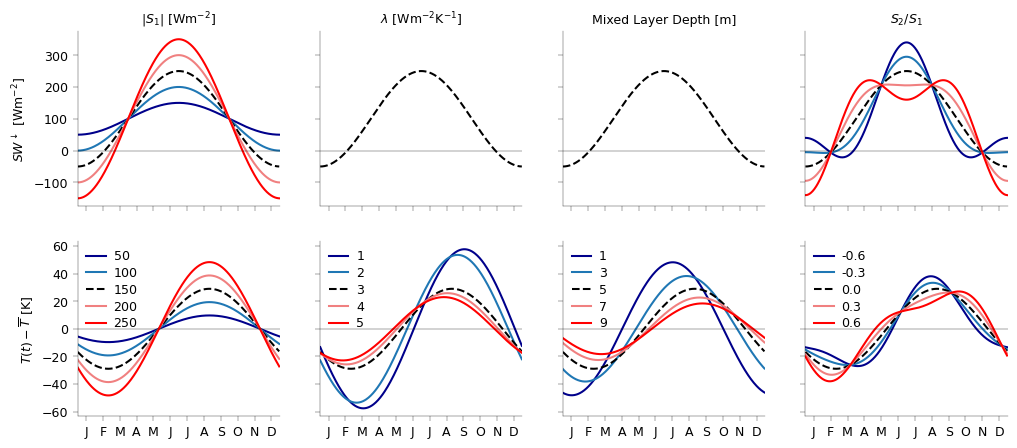

In [540]:
# get_fourier_fit(time_array, ds_single_loc.swdn_sfc, 2)[1:]
sw_amp0_plot = 200
sw_amp1_plot = -150
lambda_const_plot = 3
n_plot_lines = 5
sw_ratio = np.linspace(-0.6, 0.6, n_plot_lines)
fig, ax = plt.subplots(2,4, sharex=True, sharey='row')
fig_resize(fig, 12, ar=1.2)
colors_seq = plt.cm.coolwarm(np.linspace(0, 1, n_plot_lines))
colors_seq = np.concatenate([colors_seq[:2], np.asarray([0, 0, 0, 1])[np.newaxis], colors_seq[3:]])
for i in range(len(sw_ratio)):
    sw_plot = fourier.fourier_series(ds[0].dayofyear, [sw_amp0_plot, sw_amp1_plot, sw_amp1_plot * sw_ratio[i]], np.zeros(2))
    ax[0, 3].plot(ds[0].dayofyear, sw_plot, color=color_seq[i], linestyle='--' if i==2 else None)
    temp_plot = get_temp_fourier_analytic(ds[0].dayofyear, sw_plot, heat_capacity[0], lambda_const_plot)[0]
    ax[1, 3].plot(ds[0].dayofyear, temp_plot-np.mean(temp_plot), color=color_seq[i], linestyle='--' if i==2 else None,
                  label=f"{sw_ratio[i]:.1f}")
sw_amp1_plot = [-250, -200, -150, -100, -50][::-1]
sw_ratio = 0
for i in range(n_plot_lines):
    sw_plot = fourier.fourier_series(ds[0].dayofyear, [sw_amp0_plot, sw_amp1_plot[i], sw_amp1_plot[i] * sw_ratio], np.zeros(2))
    ax[0, 0].plot(ds[0].dayofyear, sw_plot, color=color_seq[i], linestyle='--' if i==2 else None)
    temp_plot = get_temp_fourier_analytic(ds[0].dayofyear, sw_plot, heat_capacity[0], lambda_const_plot)[0]
    ax[1, 0].plot(ds[0].dayofyear, temp_plot-np.mean(temp_plot), color=color_seq[i], linestyle='--' if i==2 else None,
                  label=f"{np.abs(sw_amp1_plot[i])}")
lambda_const_plot = [1, 2, 3, 4, 5]
sw_amp1_plot = -150
for i in range(n_plot_lines):
    if i == 2:
        sw_plot = fourier.fourier_series(ds[0].dayofyear, [sw_amp0_plot, sw_amp1_plot, sw_amp1_plot * sw_ratio], np.zeros(2))
        ax[0, 1].plot(ds[0].dayofyear, sw_plot, color=color_seq[i], linestyle='--' if i==2 else None)
    temp_plot = get_temp_fourier_analytic(ds[0].dayofyear, sw_plot, heat_capacity[0], lambda_const_plot[i])[0]
    ax[1, 1].plot(ds[0].dayofyear, temp_plot-np.mean(temp_plot), color=color_seq[i], linestyle='--' if i==2 else None,
                  label=f"{lambda_const_plot[i]:.0f}")

heat_capacity_use = [get_heat_capacity(c_p_water, rho_water, i) for i in range(1, 10,2)]
lambda_const_plot = 3
for i in range(n_plot_lines):
    if i == 2:
        sw_plot = fourier.fourier_series(ds[0].dayofyear, [sw_amp0_plot, sw_amp1_plot, sw_amp1_plot * sw_ratio], np.zeros(2))
        ax[0, 2].plot(ds[0].dayofyear, sw_plot, color=color_seq[i], linestyle='--' if i==2 else None)
    temp_plot = get_temp_fourier_analytic(ds[0].dayofyear, sw_plot, heat_capacity_use[i], lambda_const_plot)[0]
    ax[1, 2].plot(ds[0].dayofyear, temp_plot-np.mean(temp_plot), color=color_seq[i], linestyle='--' if i==2 else None,
                  label=f"{[j for j in range(1, 10,2)][i]:.0f}")


ax[0, 0].set_xlim(0,360)
ax[0, 0].set_xticks(*month_ticks)
title_row_ind = 0
ax[title_row_ind, 0].set_title('$|S_1|$ [Wm$^{-2}$]')
ax[title_row_ind, 1].set_title('$\lambda$ [Wm$^{-2}$K$^{-1}$]')
ax[title_row_ind, 2].set_title('Mixed Layer Depth [m]')
ax[title_row_ind, 3].set_title('$S_2/S_1$')
ax[0, 0].set_ylabel('$SW^{\downarrow}$ [Wm$^{-2}$]')
ax[1, 0].set_ylabel('$T(t) - \overline{T}$ [K]')
update_linewidth(fig, base_linewidth=1.8)
for ax_use in ax.flatten():
    ax_use.axhline(0, color='k', lw=ax_linewidth)
for i in range(4):
    ax[1,i].legend()
update_fontsize(fig, base_fontsize=11)
# savefig(fig)